In [1]:
%pip install --upgrade --quiet langchain-nvidia-ai-endpoints langchain-community neo4j langchain-core

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from typing import Any, Dict, List, Optional, Tuple, Type

from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain_core.tools import tool
from langchain_nvidia_ai_endpoints import ChatNVIDIA

from langchain.agents import AgentExecutor
from langchain.agents.format_scratchpad import \
    format_to_openai_function_messages
from langchain.agents.output_parsers.openai_tools import \
    OpenAIToolsAgentOutputParser
from langchain.callbacks.manager import (AsyncCallbackManagerForToolRun,
                                         CallbackManagerForToolRun)
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.pydantic_v1 import BaseModel, Field
from langchain.schema import AIMessage, HumanMessage
from langchain.tools import BaseTool
from langchain.tools.render import format_tool_to_openai_function
from langchain_community.graphs import Neo4jGraph

C:\Users\Harshit\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3667: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
%pip install neo4j-driver

   ---------------------------------------- 0.0/312.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/312.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/312.5 kB ? eta -:--:--
   --- ----------------------------------- 30.7/312.5 kB 325.1 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/312.5 kB 465.5 kB/s eta 0:00:01
   --------------------------- ------------ 215.0/312.5 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 312.5/312.5 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Update cell 4 with this code
# Update your database connection information
os.environ["NEO4J_URI"] = "bolt://44.222.250.42:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "schedule-pop-changes"

# Initialize Neo4jGraph with connection parameters
graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"], 
    password=os.environ["NEO4J_PASSWORD"],
    database="neo4j",  # Default database name
    refresh_schema=False
)

# You can also use the driver directly if needed
from neo4j import GraphDatabase, basic_auth
driver = GraphDatabase.driver(
    os.environ["NEO4J_URI"],
    auth=basic_auth(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

# Test the connection with a simple query
try:
    with driver.session(database="neo4j") as session:
        result = session.run("RETURN 'Connection successful' AS message").single()
        print(result["message"])
        print("Driver connection working")
except Exception as e:
    print(f"Driver connection error: {str(e)}")

# Don't forget to close the driver when you're done
# driver.close()

Connection successful
Driver connection working


In [32]:
os.environ["NVIDIA_API_KEY"] = "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"
llm = ChatNVIDIA(model="meta/llama-3.1-70b-instruct")

In [34]:
result = llm.invoke("How to use LLMs in combination with Graph Databases? Be concise!")
print(result.content)

Using Large Language Models (LLMs) in combination with Graph Databases can unlock powerful insights and create innovative applications. Here's a concise overview of how to combine them:

**Benefits:**

1. **Entity Disambiguation**: LLMs can help resolve entity ambiguity in graph databases.
2. **Node and Edge Labeling**: LLMs can automatically generate labels for nodes and edges.
3. **Query Augmentation**: LLMs can enhance query performance by predicting relationships.
4. **Graph Embeddings**: LLMs can generate embeddings for graph data, enabling similarity search and clustering.

**Architecture:**

1. **Graph Database**: Store and manage graph data using a graph database like Neo4j, Amazon Neptune, or TigerGraph.
2. **LLM Integration**: Integrate a pre-trained LLM (e.g., transformer-based models like BERT, RoBERTa, or T5) with the graph database using APIs or SDKs.
3. **Data Preprocessing**: Preprocess graph data into a format suitable for the LLM (e.g., node/edge lists, adjacency matr

In [20]:
graph.query(
    "CREATE FULLTEXT INDEX drug IF NOT EXISTS FOR (d:Drug) ON EACH [d.name];"
)
graph.query(
    "CREATE FULLTEXT INDEX manufacturer IF NOT EXISTS FOR (d:Manufacturer) ON EACH [d.manufacturerName];"
)

[]

In [24]:
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2) to each word, then combines them using the AND
    operator. Useful for mapping movies and people from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()


candidate_query = """
CALL db.index.fulltext.queryNodes(
$index, $query, {limit: $limit})
YIELD node
RETURN coalesce(node.manufacturerName, node.name) AS candidate,
       labels(node)[0] AS label
"""


def get_candidates(input: str, type: str, limit: int = 3) -> List[Dict[str, str]]:
    """
    Retrieve a list of candidate entities from database based on the input string.

    This function queries the Neo4j database using a full-text search. It takes the
    input string, generates a full-text query, and executes this query against the
    specified index in the database. The function returns a list of candidates
    matching the query, with each candidate being a dictionary containing their name
    (or title) and label (either 'Person' or 'Movie').
    """
    ft_query = generate_full_text_query(input)
    candidates = graph.query(
        candidate_query, {"index": type, "query": ft_query, "limit": limit}
    )
    return candidates

In [25]:
get_candidates("voriconazol", "drug")

[{'candidate': 'VORICONAZOLE', 'label': 'Drug'}]

In [44]:
@tool
def get_side_effects(
    drug: Optional[str] = Field(
        description="disease mentioned in the question. Return None if no mentioned.",
    ),
    min_age: Optional[int] = Field(
        description="Minimum age of the patient. Return None if no mentioned.",
    ),
    max_age: Optional[int] = Field(
        description="Maximum age of the patient. Return None if no mentioned.",
    ),
    manufacturer: Optional[str] = Field(
        description="manufacturer of the drug. Return None if no mentioned.",
    ),
):
    """Useful for when you need to find common side effects."""
    params = {}
    filters = []
    side_effects_base_query = """
    MATCH (c:Case)-[:HAS_REACTION]->(r:Reaction), (c)-[:IS_PRIMARY_SUSPECT]->(d:Drug)
    """
    if drug and isinstance(drug, str):
        candidate_drugs = [el["candidate"] for el in get_candidates(drug, "drug")]
        if not candidate_drugs:
            # Return empty list if drug not found
            print(f"Debug: Drug '{drug}' not found.")
            return []
        filters.append("d.name IN $drugs")
        params["drugs"] = candidate_drugs

    if min_age and isinstance(min_age, int):
        filters.append("c.age > $min_age ")
        params["min_age"] = min_age
    if max_age and isinstance(max_age, int):
        filters.append("c.age < $max_age ")
        params["max_age"] = max_age

    if manufacturer and isinstance(manufacturer, str) and manufacturer.lower() not in ['none', 'null']: # Check for 'none' or 'null'
        candidate_manufacturers = [
            el["candidate"] for el in get_candidates(manufacturer, "manufacturer")
        ]
        if not candidate_manufacturers:
            # Return empty list if manufacturer not found
            print(f"Debug: Manufacturer '{manufacturer}' not found.")
            return []
        filters.append(
             "EXISTS {(c)<-[:REGISTERED]-(m:Manufacturer) WHERE m.manufacturerName = $manufacturer}"
        )
        params["manufacturer"] = candidate_manufacturers[0]

    if filters:
        side_effects_base_query += " WHERE "
        side_effects_base_query += " AND ".join(filters)
    side_effects_base_query += """
    RETURN d.name AS drug, r.description AS side_effect, count(*) AS count
    ORDER BY count DESC
    LIMIT 10
    """
    print(f"Executing Cypher: {side_effects_base_query}")
    print(f"Using parameters: {params}")
    data = graph.query(side_effects_base_query, params=params)

    if not data:
        # Return empty list if no data found
        print("Debug: No side effects data found for query.")
        return []
    return data

In [45]:
get_side_effects("lyrica")

Executing Cypher: 
    MATCH (c:Case)-[:HAS_REACTION]->(r:Reaction), (c)-[:IS_PRIMARY_SUSPECT]->(d:Drug)
     WHERE d.name IN $drugs
    RETURN d.name AS drug, r.description AS side_effect, count(*) AS count
    ORDER BY count DESC
    LIMIT 10
    
Using parameters: {'drugs': ['LYRICA', 'LYRICA CR']}


[{'drug': 'LYRICA', 'side_effect': 'Pain', 'count': 32},
 {'drug': 'LYRICA', 'side_effect': 'Fall', 'count': 21},
 {'drug': 'LYRICA',
  'side_effect': 'Intentional product use issue',
  'count': 20},
 {'drug': 'LYRICA', 'side_effect': 'Insomnia', 'count': 19},
 {'drug': 'LYRICA', 'side_effect': 'Feeling abnormal', 'count': 18},
 {'drug': 'LYRICA', 'side_effect': 'Drug ineffective', 'count': 18},
 {'drug': 'LYRICA', 'side_effect': 'Memory impairment', 'count': 17},
 {'drug': 'LYRICA', 'side_effect': 'Withdrawal syndrome', 'count': 17},
 {'drug': 'LYRICA', 'side_effect': 'Malaise', 'count': 16},
 {'drug': 'LYRICA', 'side_effect': 'Intentional product misuse', 'count': 15}]

Graph-based LLM Agent

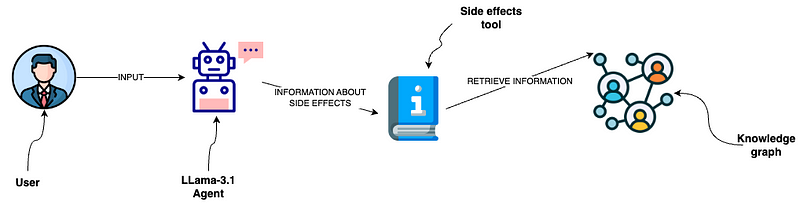

The image depicts a user interacting with a Llama-3.1 agent to inquire about drug side effects. The agent accesses a side effects tool that retrieves information from a knowledge graph to provide the user with the relevant data.

In [46]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that finds information about common side effects. "
            "If tools require follow up questions, "
            "make sure to ask the user for clarification. Make sure to include any "
            "available options that need to be clarified in the follow up questions "
            "Do only the things the user specifically requested. ",
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

def _format_chat_history(chat_history: List[Tuple[str, str]]):
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

In [51]:
# Create a new cell to implement the proper tools binding and agent setup
from langchain.pydantic_v1 import BaseModel, Field
from typing import List, Optional, Tuple

# Define proper input/output models for the agent
class AgentInput(BaseModel):
    input: str
    chat_history: Optional[List[Tuple[str, str]]] = Field(default_factory=list)

class Output(BaseModel):
    output: str

# First, let's create the llm_with_tools by properly binding the tools to the LLM
tools = [get_side_effects]

# Properly bind tools to the LLM
llm_with_tools = llm.bind_tools(
    tools=[format_tool_to_openai_function(t) for t in tools]
)

# Ensure we safely handle content for the LLM
def safe_content(content):
    """Ensure content is never empty"""
    if not content or not isinstance(content, str) or content.strip() == "":
        return "No content"
    return content

def _format_chat_history(chat_history: List[Tuple[str, str]]):
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=safe_content(human)))
        buffer.append(AIMessage(content=safe_content(ai)))
    return buffer

def safe_messages(messages):
    # Ensure every message has at least one character in content
    for m in messages:
        if hasattr(m, "content") and (not m.content or not isinstance(m.content, str) or m.content.strip() == ""):
            m.content = "No content"
    return messages

agent = (
    {
        "input": lambda x: safe_content(x["input"]),
        "chat_history": lambda x: _format_chat_history(x.get("chat_history", [])),
        "agent_scratchpad": lambda x: safe_messages(
            format_to_openai_function_messages(x.get("intermediate_steps", []))
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

# Recreate the agent executor with proper verbose settings
agent_executor = AgentExecutor(
    agent=agent, 
    tools=tools, 
    verbose=True,
    handle_parsing_errors=True  # Add error handling for parsing issues
).with_types(
    input_type=AgentInput,
    output_type=Output
)

# Let's add a simple test to ensure everything is working before the full query
test_response = agent_executor.invoke(
    {
        "input": "Hello, can you help me with drug information?"
    }
)
print("Test response:", test_response)

c:\Users\Harshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value default=PydanticUndefined description='disease mentioned in the question. Return None if no mentioned.' extra={} is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
c:\Users\Harshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value default=PydanticUndefined description='Minimum age of the patient. Return None if no mentioned.' extra={} is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
c:\Users\Harshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value default=PydanticUndefined description='Maximum age of the patie



> Entering new AgentExecutor chain...
Certainly, I can help you with drug information. 

What specifically would you like to know about this drug?

> Finished chain.
Test response: {'input': 'Hello, can you help me with drug information?', 'output': 'Certainly, I can help you with drug information. \n\nWhat specifically would you like to know about this drug?'}


The prompt template includes the system message, optional chat history, and user input. The agent_scratchpad is reserved for the LLM, as it sometimes needs to perform multiple steps to answer the question, like executing and retrieving information from tools.

The agent processes input through a series of transformations and handlers that format the chat history, apply the LLM with the bound tools, and parse the output. Finally, the agent is set up with an executor that manages the execution flow, specifies input and output types, and includes verbosity settings for detailed logging during execution.

In [52]:
agent_executor.invoke(
    {
        "input": "What are the most common side effects when using lyrica for people below 35 years old?"
    }
)



> Entering new AgentExecutor chain...

Invoking: `get_side_effects` with `{'drug': 'lyrica', 'max_age': 35, 'manufacturer': 'pfizer'}`




c:\Users\Harshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=FieldInfo(default=Pydanti...o mentioned.', extra={}), input_type=FieldInfo])
  return self.__pydantic_serializer__.to_python(


Executing Cypher: 
    MATCH (c:Case)-[:HAS_REACTION]->(r:Reaction), (c)-[:IS_PRIMARY_SUSPECT]->(d:Drug)
     WHERE d.name IN $drugs AND c.age < $max_age  AND EXISTS {(c)<-[:REGISTERED]-(m:Manufacturer) WHERE m.manufacturerName = $manufacturer}
    RETURN d.name AS drug, r.description AS side_effect, count(*) AS count
    ORDER BY count DESC
    LIMIT 10
    
Using parameters: {'drugs': ['LYRICA', 'LYRICA CR'], 'max_age': 35, 'manufacturer': 'PFIZER'}
[{'drug': 'LYRICA', 'side_effect': 'Sinusitis', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Hypoacusis', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Fall', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Brain injury', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Amnesia', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Off label use', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Impaired quality of life', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Somnolence', 'count': 1}, {'drug': 'LYRICA', 'side_effect': 'Drug ineffe

{'input': 'What are the most common side effects when using lyrica for people below 35 years old?',
 'output': 'The most common side effects of Lyrica for people below 35 years old are sinusitis, hypoacusis, fall, brain injury, amnesia, off label use, impaired quality of life, somnolence, and drug ineffective for unapproved indication.'}

In [53]:
agent_executor.invoke(
    {
        "input": "What are the most common side effects when for drugs manufactured by acadia?"
    }
)



> Entering new AgentExecutor chain...

Invoking: `get_side_effects` with `{'manufacturer': 'acadia'}`




c:\Users\Harshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=FieldInfo(default=Pydanti...o mentioned.', extra={}), input_type=FieldInfo])
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=FieldInfo(default=Pydanti...o mentioned.', extra={}), input_type=FieldInfo])
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=FieldInfo(default=Pydanti...o mentioned.', extra={}), input_type=FieldInfo])
  return self.__pydantic_serializer__.to_python(


Executing Cypher: 
    MATCH (c:Case)-[:HAS_REACTION]->(r:Reaction), (c)-[:IS_PRIMARY_SUSPECT]->(d:Drug)
     WHERE EXISTS {(c)<-[:REGISTERED]-(m:Manufacturer) WHERE m.manufacturerName = $manufacturer}
    RETURN d.name AS drug, r.description AS side_effect, count(*) AS count
    ORDER BY count DESC
    LIMIT 10
    
Using parameters: {'manufacturer': 'ACADIA PHARMACEUTICALS'}
[{'drug': 'NUPLAZID', 'side_effect': 'Hallucination', 'count': 13}, {'drug': 'NUPLAZID', 'side_effect': 'Confusional state', 'count': 7}, {'drug': 'NUPLAZID', 'side_effect': 'Fall', 'count': 6}, {'drug': 'NUPLAZID', 'side_effect': 'Delusion', 'count': 5}, {'drug': 'NUPLAZID', 'side_effect': 'Gait disturbance', 'count': 5}, {'drug': 'NUPLAZID', 'side_effect': 'Fatigue', 'count': 4}, {'drug': 'NUPLAZID', 'side_effect': 'Abnormal behaviour', 'count': 3}, {'drug': 'NUPLAZID', 'side_effect': 'Product dose omission issue', 'count': 3}, {'drug': 'NUPLAZID', 'side_effect': 'Agitation', 'count': 3}, {'drug': 'NUPLAZID', '

c:\Users\Harshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=FieldInfo(default=Pydanti...o mentioned.', extra={}), input_type=FieldInfo])
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=FieldInfo(default=Pydanti...o mentioned.', extra={}), input_type=FieldInfo])
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=FieldInfo(default=Pydanti...o mentioned.', extra={}), input_type=FieldInfo])
  return self.__pydantic_serializer__.to_python(


Executing Cypher: 
    MATCH (c:Case)-[:HAS_REACTION]->(r:Reaction), (c)-[:IS_PRIMARY_SUSPECT]->(d:Drug)
     WHERE EXISTS {(c)<-[:REGISTERED]-(m:Manufacturer) WHERE m.manufacturerName = $manufacturer}
    RETURN d.name AS drug, r.description AS side_effect, count(*) AS count
    ORDER BY count DESC
    LIMIT 10
    
Using parameters: {'manufacturer': 'ACADIA PHARMACEUTICALS'}
[{'drug': 'NUPLAZID', 'side_effect': 'Hallucination', 'count': 13}, {'drug': 'NUPLAZID', 'side_effect': 'Confusional state', 'count': 7}, {'drug': 'NUPLAZID', 'side_effect': 'Fall', 'count': 6}, {'drug': 'NUPLAZID', 'side_effect': 'Delusion', 'count': 5}, {'drug': 'NUPLAZID', 'side_effect': 'Gait disturbance', 'count': 5}, {'drug': 'NUPLAZID', 'side_effect': 'Fatigue', 'count': 4}, {'drug': 'NUPLAZID', 'side_effect': 'Abnormal behaviour', 'count': 3}, {'drug': 'NUPLAZID', 'side_effect': 'Product dose omission issue', 'count': 3}, {'drug': 'NUPLAZID', 'side_effect': 'Agitation', 'count': 3}, {'drug': 'NUPLAZID', '

{'input': 'What are the most common side effects when for drugs manufactured by acadia?',
 'output': 'Based on the information provided, the most common side effects for drugs manufactured by Acadia are:\n\n* Hallucination\n* Confusional state\n* Fall\n* Delusion\n* Gait disturbance\n* Fatigue\n* Abnormal behaviour\n* Product dose omission issue\n* Agitation\n* Death\n\nPlease note that this list only includes side effects for the drug NUPLAZID, as that is the only drug mentioned in the provided information. If you would like to know the side effects for other drugs manufactured by Acadia, please let me know and I can try to find that information for you.'}

The LLM identified it needs to use the get_side_effects function with appropriate arguments. The function then dynamically generates a Cypher statement, fetches the relevant information, and returns it to the LLM to generate the final answer.

### Summary
Function calling capabilities are a powerful addition to open-source models like Llama 3.1, enabling more structured and controlled interactions with external data sources and tools. Beyond just querying unstructured documents, graph-based agents offer exciting possibilities for interacting with knowledge graphs and structured data. The ease of hosting these models using platforms like NVIDIA NIM microservices makes them increasingly accessible.